### Methods for prevent vanishing/exploding gradient

1. Exploding gradient:
- Truncated gradient
- Penalty
- Gradient Clipping

2. Vanishing gradient:
- Weights initialization
- LSTM


In [261]:
import numpy as np
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [262]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')

In [263]:
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [264]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
Date      1258 non-null object
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null object
Volume    1258 non-null object
dtypes: float64(3), object(3)
memory usage: 59.0+ KB


Our goal will to use the 5 year google stock to predict the 'Open' at 1/1/2017

In [265]:
# import datetime
# train_data['Date'] = train_data['Date'].map(lambda x:datetime.datetime.strptime(x,"%m/%d/%Y").date())

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


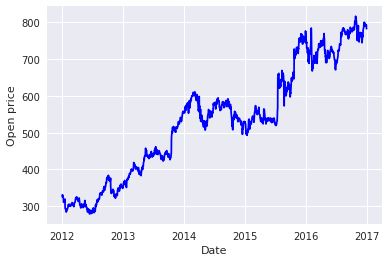

In [266]:
# Visualize trend of the stock price
import matplotlib.dates as dates
plt.plot_date(x=train_data['Date'].map(lambda x:dates.datestr2num(x)), y=train_data['Open'], xdate=True, fmt="b-")
plt.xlabel('Date')
plt.ylabel('Open price')

In [267]:
training_set = train_data.iloc[:, 1:2].values

When there are sigmoid activation functions in the neural network, it is recommendable to apply normalization for feature scaling.

In [268]:
# Apply feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

### Create a data structure with 60 time steps and 1 output

In [95]:
# Create the data stucture

X_train = []
y_train = []

for i in np.arange(60,len(training_set),1):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [96]:
X_train.shape

(1198, 60)

In [97]:
y_train.shape

(1198,)

In [100]:
# Reshape the data to follow the input requirement for Keras RNN
# Three dimensions are batch_size, time, input_dim
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))

In [101]:
# Build the RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [102]:
regressor = Sequential()

In [106]:
# Add the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(rate=0.2))

In [107]:
# Add the second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

In [108]:
# Add the third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

In [109]:
# Add the forth LSTM layer
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(rate=0.2))

In [110]:
# Add the output LSTM layer
regressor.add(Dense(1))

In [111]:
# Compile the regressor adding training methods and loss function
regressor.compile(optimizer='Adam', loss='mean_squared_error')

In [113]:
# Fit the RNN model
regressor.fit(X_train, y_train, epochs = 100, batch_size=32)

Epoch 1/100
1198/1198 [==============================] - 20s 16ms/step - loss: 0.0536

In [269]:
# Obtain test set
test_data = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = test_data.iloc[:, 1:2].values

In [270]:
# Re-concatenate the data, pay attention to the different preprocessing
data = pd.concat([train_data['Open'], test_data['Open']], axis=0)
inputs = data[len(train_data)-60:].values

In [271]:
# Scaled the data
data_input = scaler.transform(inputs.reshape(-1,1))

In [274]:
# Build the testing data
X_test = []

for i in range(60,len(data_input)):
    X_test.append(data_input[i-60:i,0])

In [276]:
X_test = np.array(X_test)
# Reshape the input as the required dimension: batch, time, feature
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [277]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [278]:
predicted_stock_price

array([[ 782.08361816],
       [ 779.29095459],
       [ 782.48895264],
       [ 784.13360596],
       [ 788.48736572],
       [ 795.7376709 ],
       [ 799.35369873],
       [ 798.22735596],
       [ 797.68103027],
       [ 797.8269043 ],
       [ 798.22650146],
       [ 798.32775879],
       [ 798.46142578],
       [ 799.76721191],
       [ 800.95281982],
       [ 808.82415771],
       [ 816.52764893],
       [ 823.01165771],
       [ 822.9486084 ],
       [ 811.93310547]], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


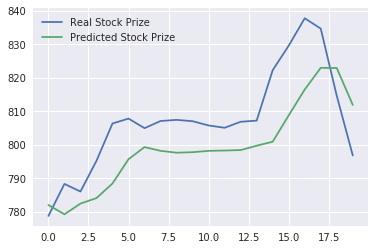

In [284]:
# Visualize trend of the stock price
plt.plot(test_data['Open'], label='Real Stock Prize')
plt.plot(predicted_stock_price, label='Predicted Stock Prize')
plt.legend()